---
### Smart Optimization to Save Computing Time
---

#### I. Load model and data

In [ ]:
import pickle

In [ ]:
with open('models/model_dt_regression.pkl', 'rb') as f:
    model_dt = pickle.load(f)

In [ ]:
model_dt

In [ ]:
import pandas as pd

df = pd.read_excel('data/Microsoft_LinkedIn_Processed.xlsx', index_col=0, parse_dates=['Date'])
df.head(n=5)

---
#### II. Parametrize & optimize the investment strategy

Create Strategy class.

In [ ]:
from backtesting import Strategy

In [ ]:
class Regression(Strategy):
    limit_buy = 1
    limit_sell = -5
    
    def init(self):
        self.model = model_dt
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

Create `Backtest` class.

In [ ]:
from backtesting import Backtest

In [ ]:
df_explanatory = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

bt = Backtest(df_explanatory, Regression,
              cash=10000, commission=.002, exclusive_orders=True)

Optimize backtesting with multiple combinations.

In [78]:
import multiprocessing as mp
mp.set_start_method('fork')

RuntimeError: context has already been set

In [79]:
stats_skopt, heatmap, optimize_result = bt.optimize(
    limit_buy=[0, 10],
    limit_sell=[-10, 0],
    maximize='Return [%]',
    method='skopt',
    max_tries=500,
    random_state=0,
    return_heatmap=True,
    return_optimization=True)

/var/folders/1g/42ndnt6971569259087l_v9w0000gn/T/ipykernel_4604/3066952252.py:1: DeprecationWarning: `Backtest.optimize(method="skopt")` is deprecated. Use `method="sambo"`.
  stats_skopt, heatmap, optimize_result = bt.optimize(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_stats.py:155: RuntimeWarning: divide by zero encountered in log
  equity_log_returns = np.log(equity[1:] / equity[:-1])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_stats.py:155: RuntimeWarning: divide by zero encountered in log
  equity_log_returns = np.log(equity[1:] / equity[:-1])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_stats.py:155: RuntimeWarning: divide by zero encountered in log
  equity_log_returns = np.log(equity[1:] / equity[:-1])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_stats.py:155: RuntimeWarning: divide by

*Which are the best values for the parameters?*

In [83]:
dff = heatmap.reset_index()
dff = dff.pivot(index='limit_buy', columns='limit_sell', values='Return [%]')
dff

limit_sell,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
limit_buy,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,661.428100,NaN,2491.122843,NaN,15788.893743,21293.370295
1,452.680764,NaN,516.573654,530.685047,606.509117,NaN,888.246013,NaN,NaN,NaN,315.583274
2,NaN,340.999309,NaN,NaN,347.406801,NaN,NaN,NaN,273.616277,NaN,NaN
3,340.999309,NaN,221.442217,NaN,NaN,62.213183,NaN,NaN,NaN,NaN,-77.555122
4,255.130013,255.130013,NaN,NaN,NaN,35.540892,-88.646554,-80.938705,-78.065288,-82.493826,-76.608931
5,255.130013,255.130013,94.375167,NaN,NaN,51.082806,NaN,NaN,NaN,-83.994015,NaN
6,124.248840,NaN,NaN,9.965521,NaN,NaN,NaN,-100.000000,NaN,-100.000000,-100.000000
7,161.400206,NaN,-100.000000,-100.000000,-100.000000,NaN,-100.000000,NaN,NaN,-100.000000,NaN
8,NaN,NaN,NaN,-100.000000,-100.000000,NaN,-100.000000,NaN,NaN,-100.000000,NaN


In [82]:
dff.style.highlight_null(props='background-color: transparent; color: transparent')

limit_sell,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
limit_buy,,,,,,,,,,,
0,nan,nan,nan,nan,nan,661.428100,nan,2491.122843,nan,15788.893743,21293.370295
1,452.680764,nan,516.573654,530.685047,606.509117,nan,888.246013,nan,nan,nan,315.583274
2,nan,340.999309,nan,nan,347.406801,nan,nan,nan,273.616277,nan,nan
3,340.999309,nan,221.442217,nan,nan,62.213183,nan,nan,nan,nan,-77.555122
4,255.130013,255.130013,nan,nan,nan,35.540892,-88.646554,-80.938705,-78.065288,-82.493826,-76.608931
5,255.130013,255.130013,94.375167,nan,nan,51.082806,nan,nan,nan,-83.994015,nan
6,124.248840,nan,nan,9.965521,nan,nan,nan,-100.000000,nan,-100.000000,-100.000000
7,161.400206,nan,-100.000000,-100.000000,-100.000000,nan,-100.000000,nan,nan,-100.000000,nan
8,nan,nan,nan,-100.000000,-100.000000,nan,-100.000000,nan,nan,-100.000000,nan


In [84]:
import numpy as np

In [85]:
dff.sort_index(axis=1, ascending=False)\
    .style.format(precision=0)\
    .background_gradient(vmin=np.nanmin(dff), vmax=np.nanmax(dff))\
    .highlight_null(props='background-color: transparent; color: transparent')

limit_sell,0,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10
limit_buy,,,,,,,,,,,
0,21293,15789,nan,2491,nan,661,nan,nan,nan,nan,nan
1,316,nan,nan,nan,888,nan,607,531,517,nan,453
2,nan,nan,274,nan,nan,nan,347,nan,nan,341,nan
3,-78,nan,nan,nan,nan,62,nan,nan,221,nan,341
4,-77,-82,-78,-81,-89,36,nan,nan,nan,255,255
5,nan,-84,nan,nan,nan,51,nan,nan,94,255,255
6,-100,-100,nan,-100,nan,nan,nan,10,nan,nan,124
7,nan,-100,nan,nan,-100,nan,-100,-100,-100,nan,161
8,nan,-100,nan,nan,-100,nan,-100,-100,nan,nan,nan


---
#### III. How to interpret smart optimization?

Number of evaluations. Check `Parameter Heatmap`: https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap%20&%20Optimization.html.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_stats.py:155: RuntimeWarning: divide by zero encountered in log
  equity_log_returns = np.log(equity[1:] / equity[:-1])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_stats.py:155: RuntimeWarning: divide by zero encountered in log
  equity_log_returns = np.log(equity[1:] / equity[:-1])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_stats.py:155: RuntimeWarning: divide by zero encountered in log
  equity_log_returns = np.log(equity[1:] / equity[:-1])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_stats.py:155: RuntimeWarning: divide by zero encountered in log
  equity_log_returns = np.log(equity[1:] / equity[:-1])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has bee

<Axes: >

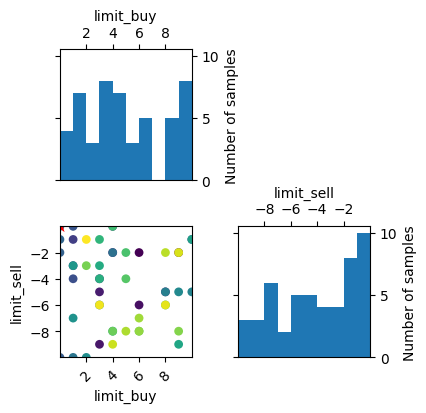

In [91]:
from skopt import gp_minimize
from skopt.space import Integer
from skopt.plots import plot_evaluations

def objective(params):
    buy, sell = params
    Regression.limit_buy = buy
    Regression.limit_sell = sell

    stats = bt.run()
    return -stats['Return [%]']

search_space = [
    Integer(0, 10, name='limit_buy'),
    Integer(-10, 0, name='limit_sell')
]

opt_result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    random_state=0
)

plot_evaluations(opt_result, bins=10)


Density.

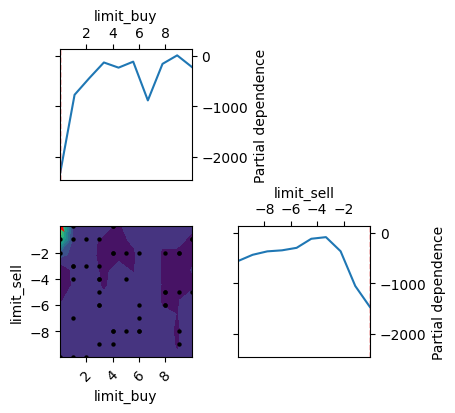

In [92]:
from skopt.plots import plot_objective

_ = plot_objective(opt_result, n_points=10)